In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import tomllib
from sklearn.metrics import r2_score
import matplotlib as mpl

import copy

In [2]:
def dew_point_cacl(t, h):
    """t- температура в градусах цельсия, h - влажность воздуха в виде ХХ"""
    a, b = 17.27, 237.7
    g = a * t / (b + t)
    h = np.clip(h, 1e-6, 100.0)
    g += np.log(h / 100)
    dp = (b * g) / (a - g)
    return dp

In [2]:
alldata= pd.read_feather("meteo.feather")
time_l =( alldata["datetime"].max() - pd.Timedelta(days=50)).replace(minute=0, second=0)
time_r = (alldata["datetime"].max() - pd.Timedelta(days=60)).replace(minute=0, second=0)
data_timesort = alldata[(alldata["datetime"] > time_r) &( time_l>alldata["datetime"])  ]
data_timesort2 = data_timesort[data_timesort["id_s"] == "5"]
# data = data_timesort[data_timesort["id_s"] == "5"].reset_index()
data = copy.copy(data_timesort2).reset_index()
# data["temp_air"] = data["temp_air"] + 8
# data["hum_air"] = data["hum_air"] + 30

работа с toml

In [3]:
from scipy.signal import savgol_filter

In [5]:
def fill_gaps_with_nan(df):
    """
    Проходит по столбцу 'datetime' исходного датафрейма.
    Если между соседними строками разрыв >20 минут —
    вставляет строки с шагом 15 минут и значениями NaN.
    Возвращает дополненный датафрейм.
    """
    df = df.copy()
    if 'datetime' not in df.columns:
        if df.index.name == 'datetime':
            df = df.reset_index()
        else:
            raise ValueError("Столбец 'datetime' не найден")
    
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime').reset_index(drop=True)
    
    result_rows = []
    
    for i in range(len(df)):
        # Добавляем текущую строку
        result_rows.append(df.iloc[i].to_dict())
        
        # Проверяем разрыв до следующей строки
        if i < len(df) - 1:
            t_curr = df.iloc[i]['datetime']
            t_next = df.iloc[i + 1]['datetime']
            
            if t_next - t_curr > pd.Timedelta(minutes=15):
                # Генерируем временные метки с шагом 15 минут между ними
                extra_times = pd.date_range(
                    start=t_curr + pd.Timedelta(minutes=5),
                    end=t_next - pd.Timedelta(minutes=1),  # чтобы не дублировать t_next
                    freq='15T'
                )
                for t in extra_times:
                    row = {'datetime': t}
                    for col in df.columns:
                        if col != 'datetime':
                            row[col] = np.nan
                    result_rows.append(row)
    
    return pd.DataFrame(result_rows).sort_values('datetime').reset_index(drop=True)

C:\Users\nik\AppData\Local\Temp\ipykernel_1744\1161550894.py:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  extra_times = pd.date_range(


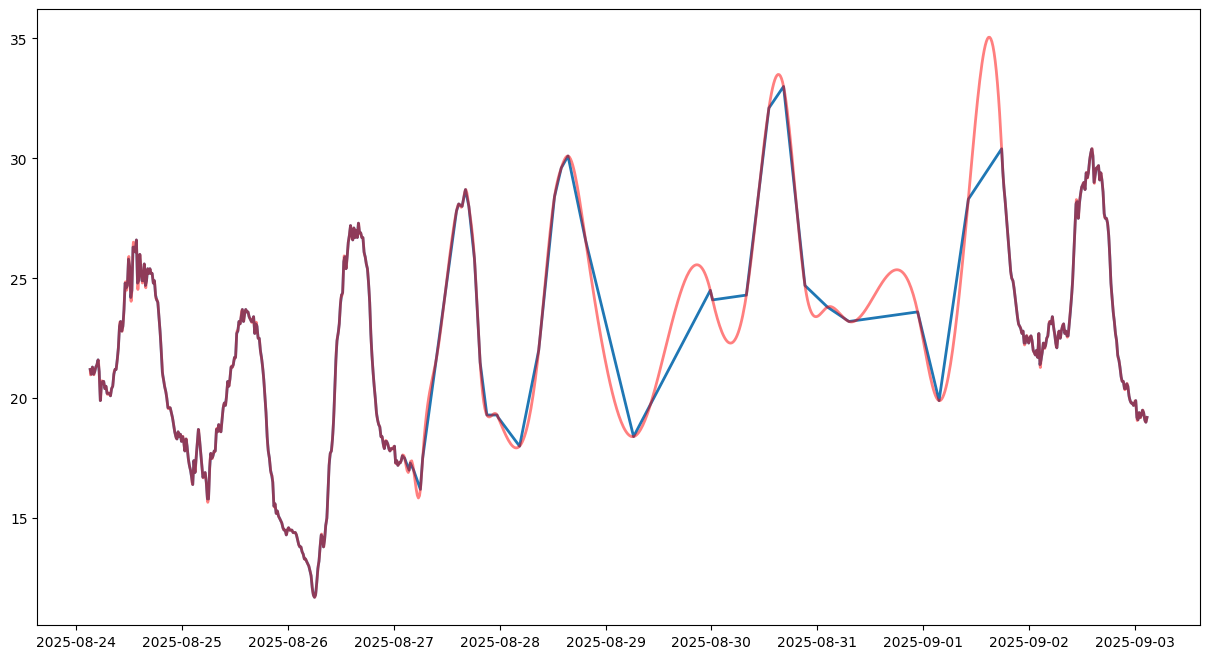

In [7]:
xt=[data['datetime'].min(),data['datetime'].max()]
x=data['datetime']
tdata=fill_gaps_with_nan(data).set_index('datetime')
# 'linear', 'time', 'index', 'values', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'barycentric', 'krogh', 
# 'spline', 'polynomial', 'from_derivatives', 'piecewise_polynomial', 'pchip', 'akima', 'cubicspline'
y=tdata['temp_air'].interpolate(method='cubicspline')
# y_smooth = savgol_filter(y, window_length=15, polyorder=2)
plt.figure(figsize=(15,8))
plt.plot(data['datetime'],data['temp_air'],lw=2)
plt.plot(y,c='red',lw=2,alpha=0.5)
# plt.plot(y.index,y_smooth,c='red')
# plt.plot(xt,[10,10])
# plt.plot(xt,[30,30])

In [158]:
y

datetime
2025-09-28 06:40:05     8.200000
2025-09-28 06:55:29     8.300000
2025-09-28 07:10:29     8.854951
2025-09-28 07:25:29     9.409902
2025-09-28 07:41:26    10.000000
                         ...    
2025-10-22 01:44:37     8.000000
2025-10-22 02:00:00     8.500000
2025-10-22 02:15:17     8.200000
2025-10-22 02:34:43     8.100000
2025-10-22 02:50:07     8.600000
Name: temp_air, Length: 2345, dtype: float64

In [143]:
df_full['temp_air'].interpolate(method='time',limit_direction='both')

2025-09-28 06:40:05    8.2
2025-09-28 07:00:05    8.2
2025-09-28 07:20:05    8.2
2025-09-28 07:40:05    8.2
2025-09-28 08:00:05    8.2
                      ... 
2025-10-22 01:20:05    8.2
2025-10-22 01:40:05    8.2
2025-10-22 02:00:05    8.2
2025-10-22 02:20:05    8.2
2025-10-22 02:40:05    8.2
Freq: 20min, Name: temp_air, Length: 1717, dtype: float64

In [95]:
def rolling_average_30min(df):
    df=df.loc[:,[ 'datetime', 'temp_air', 'hum_air', 'uv_power',
       'uv_index', 'ilum', 'hum_soil', 'temp_soil']]
    df = df.copy()
    # Устанавливаем datetime как индекс
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.set_index('datetime').sort_index()
    # Применяем временное окно
    return df.resample('30min').mean().dropna().reset_index()

import Diseas
d = Diseas.Diseas_work("deseas_grape.toml", 0)
alldata= pd.read_feather("meteo.feather")
time_l =( alldata["datetime"].max() - pd.Timedelta(days=100000)).replace(minute=0, second=0)
tdata=alldata[alldata['datetime']<time_r]

5
7
10


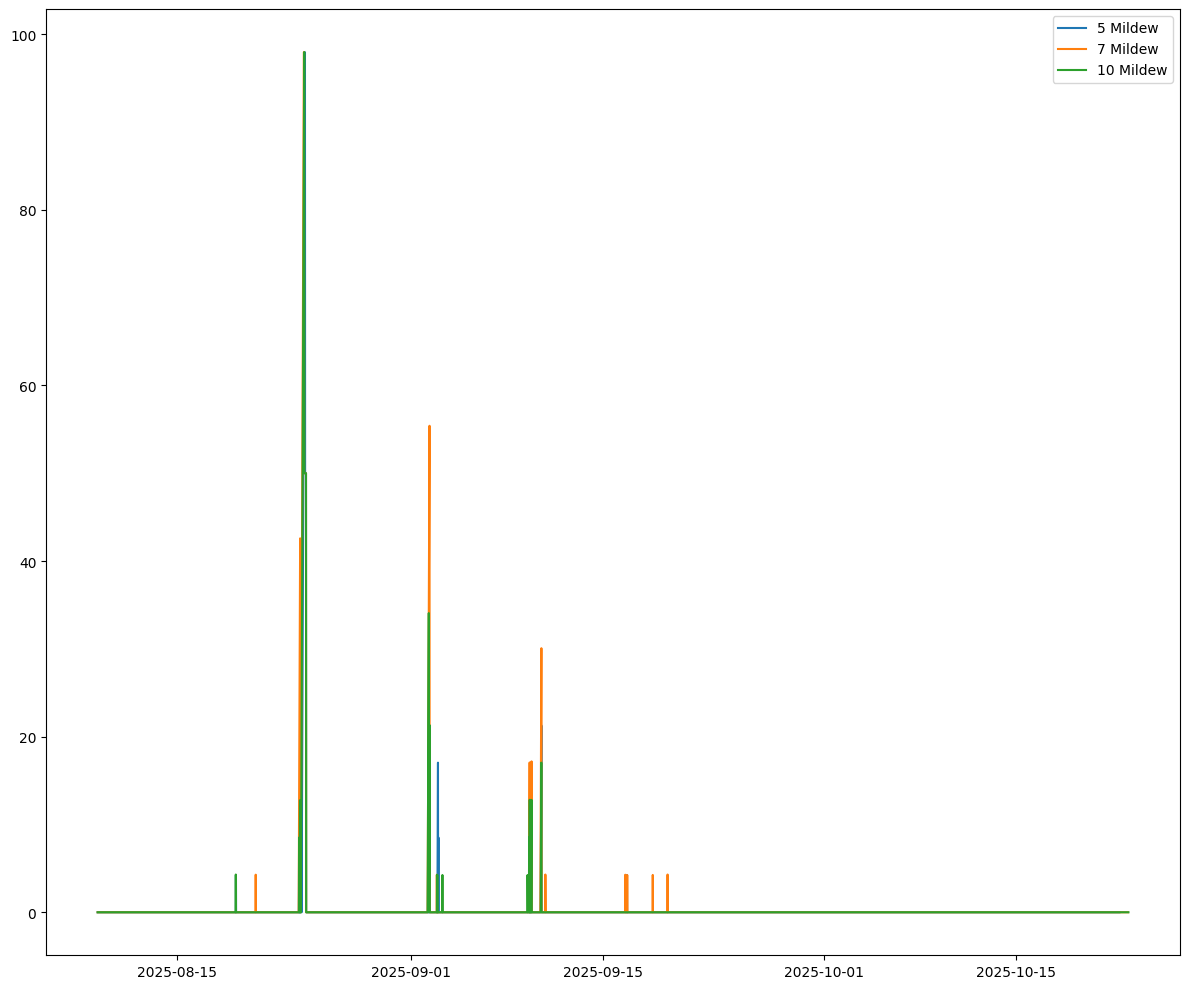

In [13]:
import Diseas
d = Diseas.Diseas_work("deseas_grape.toml", 5)
alldata= pd.read_feather("meteo.feather")
# time_l =( alldata["datetime"].max() - pd.Timedelta(days=10)).replace(minute=0, second=0)
# alldata=alldata[alldata['datetime']<time_r]

plt.figure(figsize=(12,10))
for id in alldata['id_s'].unique():
    print(id)
    d.check_time(alldata[alldata['id_s']==id],'all')
    # for d_name in d.names:
    #     print(d.prob[d_name].to_dict())
   
    for d_name in d.names:
        plt.plot(d.prob[d_name]['datetime'],d.prob[d_name]['prob'],label=id+' '+d_name)
        break
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.close()

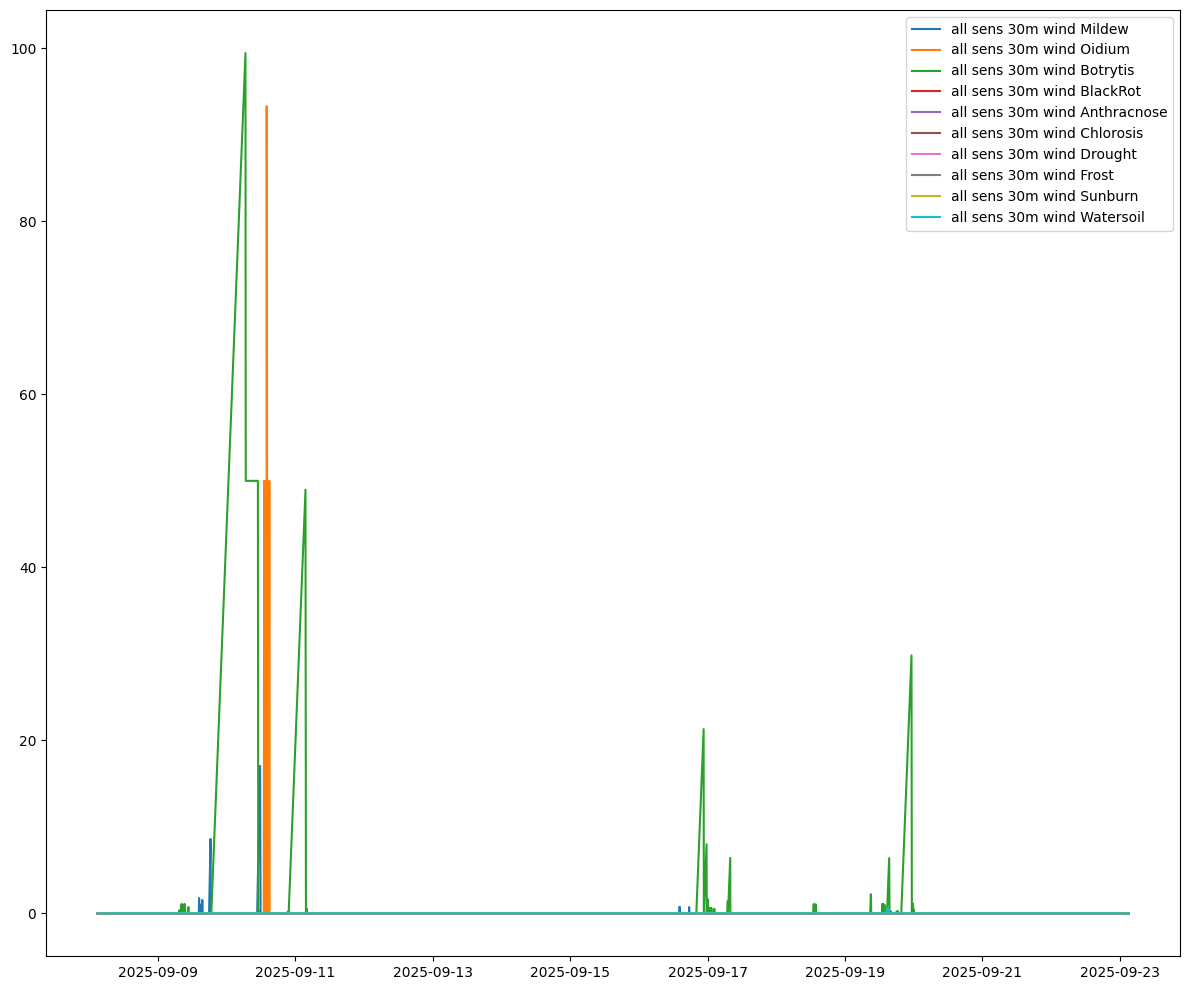

In [97]:
cdata=rolling_average_30min(alldata)
plt.figure(figsize=(12,10))
d.check_time(tdata,15*24)

for d_name in d.names:
    plt.plot(d.prob[d_name]['datetime'],d.prob[d_name]['prob'],label='all sens 30m wind '+d_name)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.close()

In [6]:
d.diseas

{'Mildew':            min    max
 temp_air  19.5   25.5
 hum_air   78.0  102.0,
 'Oidium':            min   max
 temp_air  24.5  30.5
 hum_air   58.0  82.0,
 'Botrytis':            min    max
 temp_air  14.0   26.0
 hum_air   89.0  101.0,
 'BlackRot':            min    max
 temp_air  21.5   27.5
 hum_air   89.0  101.0,
 'Anthracnose':            min    max
 temp_air  24.5   30.5
 hum_air   89.0  101.0,
 'Chlorosis':              min     max
 temp_air   19.20   28.80
 temp_soil  17.30   25.70
 hum_soil   17.50  107.50
 ph          7.35    9.15,
 'Drought':               min      max
 temp_air     26.0     74.0
 hum_air      -4.0     44.0
 uv_index      4.3     12.7
 ilum       4500.0  10500.0
 temp_soil    26.5     68.5
 hum_soil     -1.5     16.5,
 'Frost':             min  max
 temp_air  -44.0  4.0
 temp_soil -44.5  9.5,
 'Sunburn':               min      max
 temp_air     32.0     68.0
 hum_air      -4.0     44.0
 uv_power    790.0   2110.0
 uv_index      8.7     12.3
 ilum       680

In [7]:
d.diseas_check

{'Mildew': np.True_,
 'Oidium': np.True_,
 'Botrytis': np.True_,
 'BlackRot': np.True_,
 'Anthracnose': np.False_,
 'Chlorosis': np.False_,
 'Drought': np.True_,
 'Frost': np.True_,
 'Sunburn': np.False_,
 'Watersoil': np.False_}

In [17]:
for d_name in d.names:
    print(d.prob[d_name].to_dict())

{'datetime': {2: Timestamp('2025-08-09 05:57:00'), 5: Timestamp('2025-08-09 06:12:22'), 8: Timestamp('2025-08-09 06:27:40'), 11: Timestamp('2025-08-09 06:43:02'), 14: Timestamp('2025-08-09 06:58:20'), 17: Timestamp('2025-08-09 07:13:42'), 20: Timestamp('2025-08-09 07:28:59'), 23: Timestamp('2025-08-09 07:44:22'), 26: Timestamp('2025-08-09 07:59:39'), 29: Timestamp('2025-08-09 08:15:02'), 32: Timestamp('2025-08-09 08:30:19'), 35: Timestamp('2025-08-09 08:45:42'), 38: Timestamp('2025-08-09 09:00:59'), 41: Timestamp('2025-08-09 09:16:22'), 44: Timestamp('2025-08-09 09:31:39'), 47: Timestamp('2025-08-09 09:47:02'), 50: Timestamp('2025-08-09 10:02:19'), 53: Timestamp('2025-08-09 10:17:42'), 56: Timestamp('2025-08-09 10:32:59'), 59: Timestamp('2025-08-09 10:48:22'), 62: Timestamp('2025-08-09 11:03:39'), 65: Timestamp('2025-08-09 11:19:02'), 68: Timestamp('2025-08-09 11:34:19'), 71: Timestamp('2025-08-09 11:49:42'), 73: Timestamp('2025-08-09 12:04:58'), 77: Timestamp('2025-08-09 12:20:22'), 7

In [22]:
d.prob_last

{'Mildew': np.int64(0),
 'Oidium': np.int64(0),
 'Botrytis': np.int64(0),
 'BlackRot': np.int64(0),
 'Anthracnose': np.int64(0),
 'Chlorosis': np.int64(0),
 'Drought': np.int64(0),
 'Frost': np.int64(0),
 'Sunburn': np.int64(0),
 'Watersoil': np.int64(0)}

In [21]:
d.time

{'Mildew': 6,
 'Oidium': 0.1,
 'Botrytis': 12,
 'BlackRot': 24,
 'Anthracnose': 12,
 'Chlorosis': 0.1,
 'Drought': 4,
 'Frost': 12,
 'Sunburn': 4,
 'Watersoil': 24}